# Neural Net to recognise basic clouds

### Data characteristics
RGB images in 150x150 resolution
### Types recognized
* Clear Sky             A
* Patterned Clouds      B
* Thin White Clouds     C
* Thick White Clouds    D
* Thick Dark Clouds     E
* Veil Clouds           F

### Imports

In [1]:
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model

from utilities import get_dataset_partitions_tf
print(tf.version.VERSION)


2.3.0


### Hyperparameters

In [3]:
batch_size = 32
epochs = 30
training_split, val_split, test_split = 0.75, 0.15, 0.1

# parameters to save/load model
model_name = "conv-conv-pool"                  # None if not saving
model_path = "models/" + model_name

### Splitting the dataset
We will use the train-validate-test workflow.

In [7]:
swimcat_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'swimcat',
    seed=420,
    image_size=(150, 150),
    batch_size=batch_size
)
print(f"Number of batches: {int(swimcat_ds.cardinality())}")

train_ds, val_ds, test_ds = get_dataset_partitions_tf(
    swimcat_ds,
    int(swimcat_ds.cardinality()),
    training_split,
    val_split,
    test_split,
)

class_names = swimcat_ds.class_names
num_classes = len(class_names)
print(f"class names:\n{class_names}")


Found 2100 files belonging to 6 classes.
Number of batches: 66
class names:
['A-Clear Sky', 'B-Patterned Clouds', 'C-Thin White Clouds', 'D-Thick White Clouds', 'E-Thick Dark Clouds', 'F-Veil Clouds']


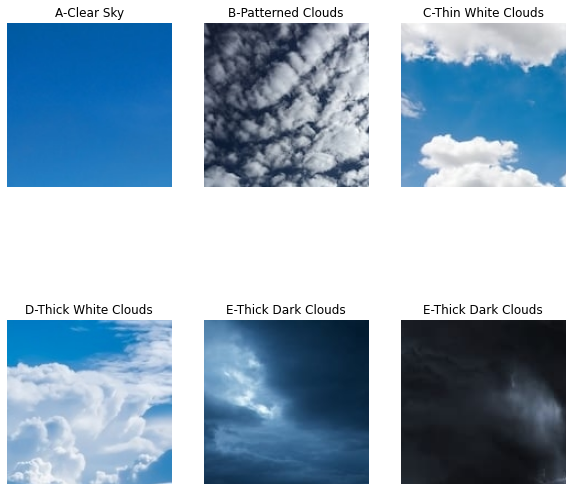

In [8]:
# Ploting some samples from our dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Some additional work before creating the net architecture

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# scaling the pixel values to fit in [0, 1] interval
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(150, 150, 3))

## Creating the Model

In [39]:
def create_model(lr=0.001):
    model = Sequential([
        normalization_layer,
        layers.Conv2D(16, 3, padding="same", activation="relu"),
        layers.Conv2D(16, 3, padding="same", activation="relu"),
        layers.MaxPool2D(3, strides=3, padding="same"),
        layers.Conv2D(32, 5, padding="same", activation="relu"),
        layers.Conv2D(32, 5, padding="same", activation="relu"),
        layers.MaxPool2D(3, strides=3, padding="same"),
        layers.Flatten(),
        layers.Dense(
            128, 
            activation="relu",
            kernel_regularizer=tf.keras.regularizers.l2(0.02)
        ),
        layers.Dense(num_classes)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.metrics.SparseCategoricalAccuracy()]
    )

    return model
my_model = None
my_model = create_model(lr=0.0005)
my_model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 50, 50, 32)        12832     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 50, 50, 32)        25632     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 17, 17, 32)       

### Training the model

In [40]:
history = my_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/30
49/49 [==============================] - 36s 737ms/step - loss: 3.1131 - sparse_categorical_accuracy: 0.4649 - val_loss: 1.4955 - val_sparse_categorical_accuracy: 0.5903
Epoch 2/30
49/49 [==============================] - 37s 765ms/step - loss: 1.1419 - sparse_categorical_accuracy: 0.6983 - val_loss: 0.8064 - val_sparse_categorical_accuracy: 0.8125
Epoch 3/30
49/49 [==============================] - 37s 761ms/step - loss: 0.8111 - sparse_categorical_accuracy: 0.7940 - val_loss: 0.6212 - val_sparse_categorical_accuracy: 0.8715
Epoch 4/30
49/49 [==============================] - 37s 759ms/step - loss: 0.6031 - sparse_categorical_accuracy: 0.8565 - val_loss: 0.4689 - val_sparse_categorical_accuracy: 0.9167
Epoch 5/30
49/49 [==============================] - 38s 765ms/step - loss: 0.4994 - sparse_categorical_accuracy: 0.8737 - val_loss: 0.4580 - val_sparse_categorical_accuracy: 0.8924
Epoch 6/30
49/49 [==============================] - 37s 761ms/step - loss: 0.4388 - sparse_cate

### Saving The model

In [41]:
my_model.save(model_path)

INFO:tensorflow:Assets written to: models/conv-conv-pool\assets


## Results

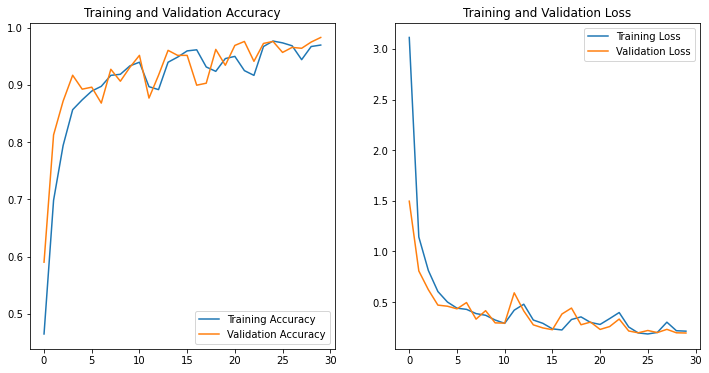

In [42]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predictions

### Test set evaluation

In [8]:
# my_model.evaluate(test_ds, verbose=True)
loaded_model = load_model(model_path)
loaded_model.evaluate(test_ds, verbose=True)

8/8 [==============================] - 1s 127ms/step - loss: 0.2004 - sparse_categorical_accuracy: 0.9766


[0.20043128728866577, 0.9765625]

### My samples prediction

Class <A-Clear Sky>, Belonging prob. 0.00
Class <B-Patterned Clouds>, Belonging prob. 99.81
Class <C-Thin White Clouds>, Belonging prob. 0.19
Class <D-Thick White Clouds>, Belonging prob. 0.00
Class <E-Thick Dark Clouds>, Belonging prob. 0.00
Class <F-Veil Clouds>, Belonging prob. 0.00

This image most likely belongs to B-Patterned Clouds with a 99.81 percent confidence.


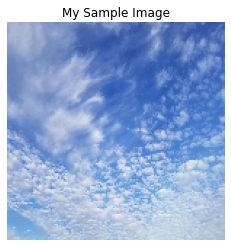

In [9]:
img_path = 'predictSamples\patterned_1.jpg'
img_sample = tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150))
img_sample = keras.preprocessing.image.img_to_array(img_sample)
img_sample = np.array([img_sample])         # img to batch

plt.imshow(img_sample[0].astype("uint8"))
plt.title("My Sample Image")
plt.axis("off")

predictions = loaded_model.predict(img_sample)
score = tf.nn.softmax(predictions[0])
for i in range(len(score)):
    print("Class <{}>, Belonging prob. {:.2f}".format(class_names[i], 100 * score[i]))
print(
    "\nThis image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
